In [1]:
import os
import numpy as np
import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.autograd import Variable
import torch.nn as nn
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, recall_score, precision_score, f1_score
import tqdm
from operator import add
import matplotlib.pyplot as plt
import easydict
import wandb
import sklearn.metrics as metrics

In [2]:
!wandb login

wandb: Currently logged in as: tonge (use `wandb login --relogin` to force relogin)


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
class ECGdataset(Dataset):
    def __init__(self, data_type):
        if data_type == 'train':
            self.X = np.load('./data_np/train.npy')
            self.y = np.load('./label_np/train.npy')
            
        elif data_type == 'val':
            self.X = np.load('./data_np/validation.npy')
            self.y = np.load('./label_np/validation.npy')
            
        assert len(self.X) == len(self.y), "length should be same between input and label"
        
        self.X = torch.FloatTensor(self.X)#cpu tensor
        self.y = torch.FloatTensor(self.y)#cpu tensor
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return {
            'X': X,
            'y_target': y
        }

### 아래에서 예측된 결과들을 0.5 기준으로 thresholding해서 0, 1로 뱉는 함수, one-hot encoding도 포함.

In [4]:
def threshold(y_pred_list):
    one_hot_list = []
    thresholded_list = []
    for x in y_pred_list:
        if x >= 0.5:# class 1
            one_hot_list.append([0, 1])
            thresholded_list.append(1)
        else:
            one_hot_list.append([1, 0])
            thresholded_list.append(0)
    return thresholded_list#np.asarray(one_hot_list), 

In [6]:
from model.resnet import resnet34

model = resnet34().to(device)

config = easydict.EasyDict({'n_epoch': 15,
                           'batch_size':64,
                           'lr': 0.001,
                           })

train_loader = DataLoader(ECGdataset(data_type = 'train'), batch_size = config.batch_size, 
                          num_workers = 8, shuffle = True)
#num_workers: cpu 여러개로 학습을 시켜라(8)
test_loader = DataLoader(ECGdataset(data_type = 'val'), batch_size = config.batch_size ,num_workers = 8, shuffle = False)

#Loss
criterion = nn.BCELoss()
#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = config.lr)

#trainer
wandb.init(project="HDAI", entity="hdai_sjmaster", config = config)
wandb.watch(model, log='all')

start = torch.cuda.Event(enable_timing = True)
end = torch.cuda.Event(enable_timing = True)

start.record()
loss_plot, val_loss_plot = [], []

for n_epoch in range(1, config.n_epoch + 1):
    print(f'Train Epoch {n_epoch} start!')
    avg_train_loss = 0
    avg_train_mae = 0
    
    model.train()
    
    for iter, batch in enumerate(train_loader):
        X = batch['X'].to(device)
        y_target = batch['y_target'].to(device)
        optimizer.zero_grad()#optimizer reset
        
        y_pred = model(X)
        loss = criterion(y_pred, y_target)
        loss.backward()
        optimizer.step()
        avg_train_loss += loss.item() / len(train_loader)

    print('[Train] loss: {:.3f}'.format(avg_train_loss))

    loss_plot.append(avg_train_loss)


        #validation
    model.eval()
    avg_test_loss = 0
        
    with torch.no_grad(): #no need to compute gradient
        y_pred_list = []
        for iter, batch in enumerate(test_loader):
            X = batch['X'].to(device)
            y_target = batch['y_target'].to(device)
            y_pred = model(X)
            y_pred_list.append(y_pred)#####
            loss = criterion(y_pred, y_target)
            avg_test_loss += loss.item()/len(test_loader)


        print('[Test]  loss: {:.3f}'.format(avg_test_loss))
        print('\n')
        val_loss_plot.append(avg_test_loss)
        y_predicted = torch.cat([*y_pred_list], dim = 0)

#         wandb.log({'Train bce Loss' : avg_train_loss, 'Test bce Loss': avg_test_loss})
        wandb.log({"train": {"loss": avg_train_loss}, "val": {"loss": avg_test_loss}})
        y_target = ECGdataset(data_type = 'val').y
        y_pred, y_predicted = threshold(y_predicted)
        wandb.log({"roc" : wandb.plot.roc_curve( y_target, y_pred)})#, labels=['normal', 'arrhythmia']이거 분명 이상한데

        print("Area Under the Curve(AOC): ",roc_auc_score(y_target, y_predicted))#Compute Area Under the (ROC AUC) from prediction scores.
        print("Average Precision: ",average_precision_score(y_target, y_predicted))#Compute average precision (AP) from prediction scores.

        print(accuracy_score(y_target,y_predicted))
        print(recall_score(y_target, y_predicted))
        print(precision_score(y_target, y_predicted))
        print(f1_score(y_target, y_predicted))#조화평균이라는데
        print()
        
end.record()
torch.cuda.synchronize()
print(start.elapsed_time(end), "ms")
# torch.save(model.state_dict(), './trained_params/epoch_45_model_trial_2')

wandb.finish()


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tonge (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train Epoch 1 start!


/home/chaeeun/.conda/envs/sce/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


[Train] loss: 0.265
[Test]  loss: 0.225


Area Under the Curve(AOC):  0.9189026605734638
Average Precision:  0.8516614127459355
0.9152088907182547
0.9636608344549125
0.8664784187172246
0.9124893797790994

Train Epoch 2 start!
[Train] loss: 0.101
[Test]  loss: 0.141


Area Under the Curve(AOC):  0.9578751064007628
Average Precision:  0.9159187868474523
0.9555464087260753
0.9860924181247196
0.922366764582459
0.9531656548135299

Train Epoch 3 start!
[Train] loss: 0.084
[Test]  loss: 0.093


Area Under the Curve(AOC):  0.9606341059009567
Average Precision:  0.9519135300651965
0.963161144268368
0.9300134589502019
0.9890267175572519
0.9586127167630059

Train Epoch 4 start!
[Train] loss: 0.074
[Test]  loss: 0.061


Area Under the Curve(AOC):  0.9749481003092659
Average Precision:  0.9616934527807938
0.9755093640666804
0.968147151188874
0.9782411604714415
0.9731679819616684

Train Epoch 5 start!
[Train] loss: 0.073
[Test]  loss: 0.097


Area Under the Curve(AOC):  0.9595165354035211
Average Pr

_runtime,1441
_timestamp,1639309928
_step,29


_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


In [7]:
torch.save(model.state_dict(), './trained_params/epoch_15_0.001_20:41')

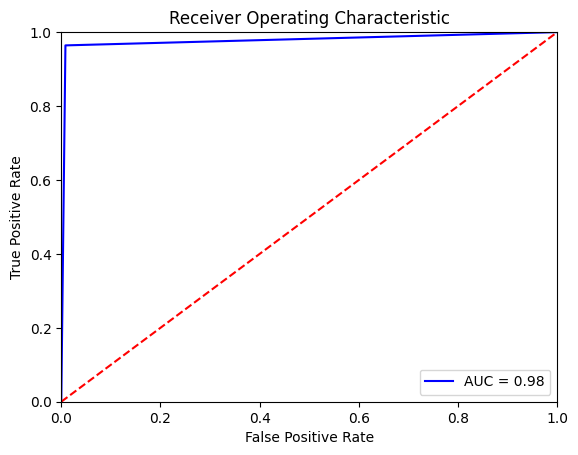

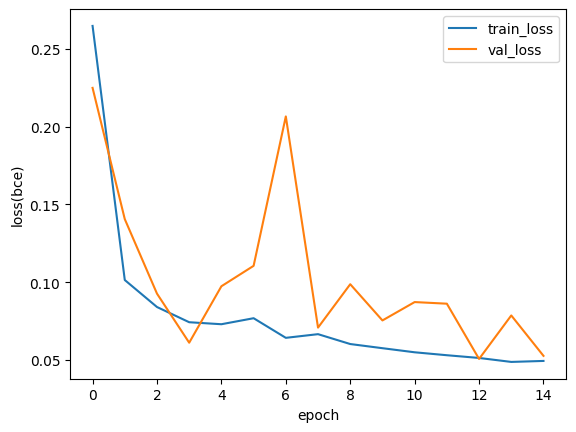

In [8]:
###visualize in this notebook
fpr, tpr, threshold = metrics.roc_curve(y_target, y_predicted)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss(bce)')
plt.legend()
plt.show()

In [10]:
len(loss_plot)

45

# saving models

In [1]:
import os
import numpy as np
import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.autograd import Variable
import torch.nn as nn
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, recall_score, precision_score, f1_score
import tqdm
from operator import add
import matplotlib.pyplot as plt
import easydict
import wandb
import sklearn.metrics as metrics
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
# torch.save(model.state_dict(), './trained_params/epoch_100_model_trial_1')
from model.resnet import resnet34
model = resnet34()
model.load_state_dict(torch.load('./trained_params/epoch_45_model_trial_2',map_location=torch.device(device)))



<All keys matched successfully>

In [6]:
criterion = nn.BCELoss()

# config = easydict.EasyDict({'n_epoch': 3,
#                            'batch_size':64,
#                            'lr': 0.001,
#                            })

test_loader = DataLoader(ECGdataset(data_type = 'val'), batch_size = 4859,num_workers = 8, shuffle = False)
# avg_test_loss=[]


In [7]:
len(test_loader)

1

In [8]:
y_pred_list = []
for iter, batch in enumerate(test_loader):
    X = batch['X']
    y_target = batch['y_target']
    y_pred = model(X)
    y_pred_list.append(y_pred)

print('\n')
# val_loss_plot.append(avg_test_loss)
y_predicted = torch.cat([*y_pred_list], dim = 0)

/home/chaeeun/.conda/envs/sce/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [9]:
y_target = ECGdataset(data_type = 'val').y
y_predicted = threshold(y_predicted)
# wandb.log({"roc" : wandb.plot.roc_curve( y_target, y_pred)})#, labels=['normal', 'arrhythmia']이거 분명 이상한데

print("Area Under the Curve(AOC): ",roc_auc_score(y_target, y_predicted))#Compute Area Under the (ROC AUC) from prediction scores.
print("Average Precision: ",average_precision_score(y_target, y_predicted))#Compute average precision (AP) from prediction scores.

print(accuracy_score(y_target,y_predicted))
print(recall_score(y_target, y_predicted))
print(precision_score(y_target, y_predicted))
print(f1_score(y_target, y_predicted))#조화평균이라는데
print()

Area Under the Curve(AOC):  0.9766782321523914
Average Precision:  0.9669637209297393
0.9775674006997325
0.9659039928218932
0.984903934126258
0.9753114382785957



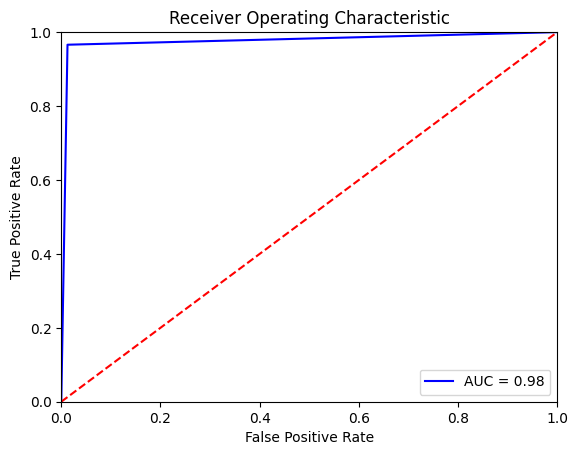

NameError: name 'loss_plot' is not defined

In [12]:
fpr, tpr, threshold = metrics.roc_curve(y_target, y_predicted)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss(bce)')
plt.legend()
plt.show()

In [10]:
sum = 0
for i in range(4859):
    if y_predicted[i] == y_target[i]:
        sum += 1
print(sum)

4750


In [11]:
4750/4859*100

97.75674006997325

epoch_15_8:41: 0.9744843720947688
final(0.0001, 100): 0.9597611505440725
epoch_100_model_trial_1: Area Under the Curve(AOC):  0.9722985294092562
epoch_45_model_trial_2: Area Under the Curve(AOC):  0.9766782321523914